In [ ]:
!pip install timm
!pip install lightning
!pip install astropy
import torch
import torch.nn as nn
import timm
import numpy as np
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm


import sys
sys.path.append('/content/')

from dataloader_fits_cr import SunImageDataset

from lightning.fabric import Fabric

import math
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import pandas as pd

import scipy.stats as stats

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 82.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 75.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 44.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 36.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 16.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 92.4 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitli

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import zipfile

zip_path = '/content/drive/MyDrive/Dataset/aia_synoptic_copy_1.zip'
extract_path = '/content/'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

In [ ]:
# Hyper-parameters
input_size = 224*224
hidden_size = 166
# hidden_size = 1024
num_epochs = 10
batch_size = 2
learning_rate = 0.001
dropout = 0.5
lstm_layers = 2

k_folds = 5

In [ ]:
import random
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)

set_seed(42)

In [ ]:
dataset = SunImageDataset(csv_file="/content/dataset_full_with_cr_5days.csv", offset=0)

total_size = len(dataset)
fold_size = total_size // k_folds
indices = list(range(total_size))

k_fold_1_indices = indices[:fold_size]
k_fold_2_indices = indices[fold_size:2*fold_size]
k_fold_3_indices = indices[2*fold_size:3*fold_size]
k_fold_4_indices = indices[3*fold_size:4*fold_size]
k_fold_5_indices = indices[4*fold_size:]

print(len(k_fold_1_indices))
print(len(k_fold_2_indices))
print(len(k_fold_3_indices))
print(len(k_fold_4_indices))
print(len(k_fold_5_indices))

dataloaders = [k_fold_1_indices, k_fold_2_indices, k_fold_3_indices, k_fold_4_indices, k_fold_5_indices]

# Get date list
kp_dates = pd.read_csv("/content/matched_kp_dates_full_with_cr_5days.csv")
kp_dates_list = kp_dates["date"].tolist()

1097
1097
1097
1097
1099


In [ ]:
# Get active indices
dataset_csv_file = pd.read_csv("/content/dataset_full_with_cr_5days.csv")
active_indices = []

for i in dataset_csv_file.index:
    if dataset_csv_file['Kp'][i] >= 3.667:
        active_indices.append(i)

active_dataloaders = []
for dataloader in dataloaders:
    active_dataloaders.append(list(set(dataloader) & set(active_indices)))

for dataloader in active_dataloaders:
    print(len(dataloader))

241
222
393
438
282


In [ ]:

class GmiSwinTransformer(nn.Module):
    def __init__(self, hidden_size: int):
        super(GmiSwinTransformer, self).__init__()

        # Batch normalization for 3 channels
        self.bn = nn.BatchNorm2d(3)

        # Initialize Swin Transformer
        self.pretrained_model = timm.create_model(
            'swin_base_patch4_window7_224',
            pretrained=True,
            num_classes=hidden_size
        )

        self.lstm = nn.LSTM(hidden_size, hidden_size * 2, lstm_layers, batch_first=True)

        # Fully connected layers
        self.fc = nn.Sequential(
            nn.LeakyReLU(),
            nn.Dropout(p=dropout),
            nn.Linear((hidden_size*2) + 2, hidden_size),
            nn.Dropout(p=dropout),  # Added dropout probability
            nn.LeakyReLU(),
            nn.Linear(hidden_size, 1),

        )

    def forward(self, images, kp) -> torch.Tensor:
        """
        Batch should be in format:
        {
            'images': torch.FloatTensor((10, 1, 224, 224))
        }
        """

        batch_size = images.shape[0]

        images = images.reshape(-1, 1, 224, 224)
        images = torch.cat([images, images, images], dim=1)
        normalized_images = self.bn(images)
        features = self.pretrained_model(normalized_images)
        image_features = features.view(batch_size, 10, -1)
        # hidden_states = torch.zeros(lstm_layers, image_features.size(0), hidden_size * 2)
        # cell_states = torch.zeros(lstm_layers, image_features.size(0), hidden_size * 2)
        # image_features, _ = self.lstm(image_features, (hidden_states, cell_states))
        image_features, _ = self.lstm(image_features)
        image_features = image_features[:, -1, :]
        kp = kp.reshape(batch_size, 1)
        kp = kp.repeat(1, 2)
        image_features = torch.cat((image_features, kp), dim=1)
        output = self.fc(image_features)
        return output

# Initialize model
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# model = GmiSwinTransformer(hidden_size=hidden_size).to(device)
model = GmiSwinTransformer(hidden_size=hidden_size)

# print(torchsummary.summary(model, (10, 1, 224, 224)))

# Loss and optimizer
criterion = nn.MSELoss()

model.safetensors:   0%|          | 0.00/353M [00:00<?, ?B/s]

In [ ]:
torch.cuda.empty_cache()

In [ ]:
def calculate_rates(all_outputs, all_labels):
    storm_labels = []
    for output in all_labels:
        if output < 3.667:
            storm_labels.append(0)
        else:
            storm_labels.append(1)
    storm_outputs = []
    for output in all_outputs:
        if output < 3.667:
            storm_outputs.append(0)
        else:
            storm_outputs.append(1)

    # Calculate true positive, true negative, false positive, false negative
    tp = 0
    tn = 0
    fp = 0
    fn = 0

    for i in range(len(storm_labels)):
        if storm_labels[i] == 1 and storm_outputs[i] == 1:
            tp += 1
        elif storm_labels[i] == 0 and storm_outputs[i] == 0:
            tn += 1
        elif storm_labels[i] == 0 and storm_outputs[i] == 1:
            fp += 1
        elif storm_labels[i] == 1 and storm_outputs[i] == 0:
            fn += 1

    return tp, tn, fp, fn


def true_skill_score(tp, tn, fp, fn):

    # Calculate true skill score
    tss = (tp / (tp + fp)) - (fp / (fp + tn)) if ((tp > 0 and tn > 0) or fp > 0) else 0
    return tss

def calculate_metrics(tp, tn, fp, fn):
    # Calculate accuracy
    accuracy = (tp + tn) / (tp + tn + fp + fn) if (tp + tn + fp + fn) > 0 else 0

    # Calculate precision
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0

    # Calculate recall
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0

    # Calculate F1 score
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0

    return accuracy, precision, recall, f1





In [ ]:
def train_model(fabric):
  print(fabric.device)
  total_avg_test_loss = 0
  total_rmse = 0
  total_mse = 0
  total_mae = 0
  total_r2 = 0
  total_r = 0
  total_tts = 0
  total_accuracy = 0
  total_precision = 0
  total_recall = 0
  total_f1 = 0

  active_total_avg_test_loss = 0
  active_total_rmse = 0
  active_total_mse = 0
  active_total_mae = 0
  active_total_r2 = 0
  active_total_r = 0


  for i in range(k_folds):
      print(f'FOLD {i + 1}')
      print('--------------------------------')
      test_indices = dataloaders[i]
      active_test_indices = active_dataloaders[i]
      train_indices = []
      for j in range(k_folds):
          if j != i:
              train_indices += dataloaders[j]

      trainloader = torch.utils.data.DataLoader(dataset=torch.utils.data.Subset(dataset, train_indices), batch_size=batch_size, shuffle=True, num_workers=20, prefetch_factor=6, pin_memory=True, worker_init_fn=lambda _: np.random.seed(42))
      testloader = torch.utils.data.DataLoader(dataset=torch.utils.data.Subset(dataset, test_indices), batch_size=batch_size, shuffle=False, num_workers=20, prefetch_factor=6, pin_memory=True)
      active_testloader = torch.utils.data.DataLoader(dataset=torch.utils.data.Subset(dataset, active_test_indices), batch_size=batch_size, shuffle=False, num_workers=20, prefetch_factor=6, pin_memory=True)
      trainloader = fabric.setup_dataloaders(trainloader)
      testloader = fabric.setup_dataloaders(testloader)
      active_testloader = fabric.setup_dataloaders(active_testloader)


      # Reinitialize model
      model = GmiSwinTransformer(hidden_size=hidden_size)
      optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
      model, optimizer = fabric.setup(model, optimizer)
      model.train()

      # Training the model
      n_total_steps = len(trainloader)
      avg_train_loss_over_epochs = []
      avg_val_loss_over_epochs = []

      for epoch in range(num_epochs):
          train_losses = []
          val_losses = []

          # Training loop
          model.train()
          for i, (images, labels, p_Kp) in tqdm(enumerate(trainloader), desc=f"Training Progress: Epoch: {epoch + 1}", total=len(trainloader)):
              # Move images and labels to device
              images = images.float()
              labels = labels.float()
              p_Kp = p_Kp.float()

              # Forward pass with autograd
              outputs = model(images, p_Kp).squeeze(1)
              loss = criterion(outputs, labels)
              # tqdm.write(f"Epoch: {epoch+1}, Index: {i}, Loss: {loss.item():.4f}")

              # Backward pass and optimization
              optimizer.zero_grad()
              fabric.backward(loss)
              optimizer.step()
              # Store the loss
              train_losses.append(loss.item())

          # Store the average training loss for this epoch
          avg_train_loss_over_epochs.append(sum(train_losses) / len(train_losses))
          print("Average Training Loss: ", sum(train_losses) / len(train_losses))

          # Validation loop
          model.eval()
          with torch.no_grad():
              for images, labels, p_Kp in tqdm(testloader, desc=f"Validation Progress: Epoch: {epoch + 1}", total=len(testloader)):
                  images = images.float()
                  p_Kp = p_Kp.float()
                  # images = images.permute(1, 0, 2, 3, 4)
                  labels = labels.float()
                  outputs = model(images, p_Kp).squeeze(1)
                  loss = criterion(outputs, labels)
                  # print("Validation Loss: ", loss.item())
                  val_losses.append(loss.item())

          # Store the average validation loss for this epoch
          avg_val_loss_over_epochs.append(sum(val_losses) / len(val_losses))
          print("Average Validation Loss: ", sum(val_losses) / len(val_losses))

      # Plot loss over epochs
      plt.figure()
      plt.plot(range(1, num_epochs + 1), avg_train_loss_over_epochs, label='Average Training Loss', marker='o')
      plt.plot(range(1, num_epochs + 1), avg_val_loss_over_epochs, label='Average Validation Loss', marker='o')
      plt.xticks(range(1, num_epochs + 1))  # Ensure x-axis includes all epoch numbers
      plt.xlabel('Epoch')
      plt.ylabel('Average Loss')
      plt.legend()
      plt.title('Training and Validation Loss Over Epochs')
      plt.show()

      test_losses = []
      all_labels = []
      all_outputs = []

      model.eval()

      print('--------------------------------')
      print('Test for Full set')
      print('--------------------------------')

  # Test for Full set
      with torch.no_grad():
          for images, labels, p_Kp in tqdm(testloader, desc="Testing Progress"):
              images = images.float()
              # images = images.permute(1, 0, 2, 3, 4)
              labels = labels.float()
              p_Kp = p_Kp.float()
              # print("Label: ", labels)
              outputs = model(images, p_Kp).squeeze(1)
              # print("Output: ", outputs)
              loss = criterion(outputs, labels)
              test_losses.append(loss.item())
              all_labels.extend(labels.cpu().numpy())
              all_outputs.extend(outputs.cpu().numpy())

      avg_test_loss = sum(test_losses) / len(test_losses)
      rmse = math.sqrt(avg_test_loss)
      mse = mean_squared_error(all_labels, all_outputs)
      mae = mean_absolute_error(all_labels, all_outputs)
      r2 = r2_score(all_labels, all_outputs)
      r, _ = stats.pearsonr(all_labels, all_outputs)
      tp, tn, fp, fn = calculate_rates(all_outputs, all_labels)
      accuracy, precision, recall, f1 = calculate_metrics(tp, tn, fp, fn)
      tts = true_skill_score(tp, tn, fp, fn)



      # Accumulate metrics for averaging across folds
      total_avg_test_loss += avg_test_loss
      total_rmse += rmse
      total_mse += mse
      total_mae += mae
      total_r2 += r2
      total_r += r
      total_tts += tts
      total_accuracy += accuracy
      total_precision += precision
      total_recall += recall
      total_f1 += f1


      print(f'Average test loss: {avg_test_loss:.4f}')
      print(f'RMSE: {rmse:.4f}')
      print(f'MSE: {mse:.4f}')
      print(f'MAE: {mae:.4f}')
      print(f'R²: {r2:.4f}')
      print(f'R: {r:.4f}')
      print(f'True Skill Score: {tts:.4f}')
      print(f'Accuracy: {accuracy:.4f}')
      print(f'Precision: {precision:.4f}')
      print(f'Recall: {recall:.4f}')
      print(f'F1 Score: {f1:.4f}')

      test_dates = list(kp_dates_list[i] for i in test_indices)
      # Convert to pandas Series for easy rolling average calculation
      labels_series = pd.Series(all_labels)
      outputs_series = pd.Series(all_outputs)

      # Calculate rolling averages with window size of 5
      window_size = 2
      labels_rolling = labels_series.rolling(window=window_size, center=True).mean()
      outputs_rolling = outputs_series.rolling(window=window_size, center=True).mean()

      # Create a better-looking plot
      plt.figure(figsize=(50, 6), facecolor='#f8f9fa')
      plt.plot([0, len(test_dates)], [3.667, 3.667], 'r--', alpha=0.6, label='Kp = 4-')
      # Plot original data with thin lines
      plt.plot(all_labels, '-', color='#1f77b4', linewidth=1, alpha=0.6, label='Actual Labels')
      plt.plot(all_outputs, '--', color='#ff7f0e', linewidth=1, alpha=0.6, label='Predicted Labels')

      # Plot smoothed data with thicker lines
      plt.plot(labels_rolling, '-', color='#2c5282', linewidth=2.5, label='Actual Labels (Smoothed)')
      plt.plot(outputs_rolling, '--', color='#c05621', linewidth=2.5, label='Predicted Labels (Smoothed)')

      # Format x-axis with dates
      test_dates_sliced = test_dates[0:len(all_labels):20]
      plt.xticks(range(0, len(test_dates), 20), test_dates_sliced, rotation=30, ha='right')

      # Better grid styling
      plt.grid(True, linestyle='--', alpha=0.7)

      # Improve labels and title
      plt.xlabel('Date', fontsize=12)
      plt.ylabel('KP Index', fontsize=12)
      plt.title('Comparison of Actual vs Predicted KP Index Values', fontsize=14)

      # Better legend
      plt.legend(loc='best', frameon=True, fontsize=12)

      # Adjust layout for better spacing
      plt.tight_layout()

      plt.show()
      print(all_outputs)

      print('--------------------------------')
      print('Test for Active Periods')
      print('--------------------------------')

      test_losses = []
      all_labels = []
      all_outputs = []

  # Test for active periods
      with torch.no_grad():
          for images, labels, p_Kp in tqdm(active_testloader, desc="Testing Progress"):
              images = images.float()
              labels = labels.float()
              p_Kp = p_Kp.float()
              outputs = model(images, p_Kp).squeeze(1)
              loss = criterion(outputs, labels)
              test_losses.append(loss.item())
              all_labels.extend(labels.cpu().numpy())
              all_outputs.extend(outputs.cpu().numpy())

      avg_test_loss = sum(test_losses) / len(test_losses)
      rmse = math.sqrt(avg_test_loss)
      mse = mean_squared_error(all_labels, all_outputs)
      mae = mean_absolute_error(all_labels, all_outputs)
      r2 = r2_score(all_labels, all_outputs)
      r, _ = stats.pearsonr(all_labels, all_outputs)
      tp, tn, fp, fn = calculate_rates(all_outputs, all_labels)
      accuracy, precision, recall, f1 = calculate_metrics(tp, tn, fp, fn)
      tts = true_skill_score(tp, tn, fp, fn)



      # Accumulate metrics for averaging across folds
      active_total_avg_test_loss += avg_test_loss
      active_total_rmse += rmse
      active_total_mse += mse
      active_total_mae += mae
      active_total_r2 += r2
      active_total_r += r




      print(f'Average test loss: {avg_test_loss:.4f}')
      print(f'RMSE: {rmse:.4f}')
      print(f'MSE: {mse:.4f}')
      print(f'MAE: {mae:.4f}')
      print(f'R²: {r2:.4f}')
      print(f'R: {r:.4f}')
      print(f'True Skill Score: {tts:.4f}')
      print(f'Accuracy: {accuracy:.4f}')
      print(f'Precision: {precision:.4f}')
      print(f'Recall: {recall:.4f}')
      print(f'F1 Score: {f1:.4f}')
      # Convert to pandas Series for easy rolling average calculation
      labels_series = pd.Series(all_labels)
      outputs_series = pd.Series(all_outputs)

      # Calculate rolling averages with a window size of 5
      window_size = 2
      labels_rolling = labels_series.rolling(window=window_size, center=True).mean()
      outputs_rolling = outputs_series.rolling(window=window_size, center=True).mean()

      # Create a better-looking plot
      plt.figure(figsize=(50, 6), facecolor='#f8f9fa')

      plt.plot([0, len(all_labels)], [3.667, 3.667], 'r--', alpha=0.6, label='Kp = 4-')

      # Plot original data with thin lines
      plt.plot(all_labels, '-', color='#1f77b4', linewidth=1, alpha=0.6, label='Actual Labels')
      plt.plot(all_outputs, '--', color='#ff7f0e', linewidth=1, alpha=0.6, label='Predicted Labels')

      # Plot smoothed data with thicker lines
      plt.plot(labels_rolling, '-', color='#2c5282', linewidth=2.5, label='Actual Labels (Smoothed)')
      plt.plot(outputs_rolling, '--', color='#c05621', linewidth=2.5, label='Predicted Labels (Smoothed)')

      # Better grid styling
      plt.grid(True, linestyle='--', alpha=0.7)

      # Improve labels and title
      plt.xlabel('Sample Index', fontsize=12)
      plt.ylabel('KP Index', fontsize=12)
      plt.title('Comparison of Actual vs Predicted KP Index Values', fontsize=14)

      # Better legend
      plt.legend(loc='best', frameon=True, fontsize=12)

      # Adjust layout for better spacing
      plt.tight_layout()

      plt.show()
      print(all_outputs)


  print('--------------------------------')
  print('Metrics for Full Set')
  print('--------------------------------')

  # Average metrics across all folds
  total_avg_test_loss /= k_folds
  total_rmse /= k_folds
  total_mse /= k_folds
  total_mae /= k_folds
  total_r2 /= k_folds
  total_r /= k_folds
  total_tts /= k_folds
  total_accuracy /= k_folds
  total_precision /= k_folds
  total_recall /= k_folds
  total_f1 /= k_folds

  print(f'Average test loss across all folds: {total_avg_test_loss:.4f}')
  print(f'Average RMSE across all folds: {total_rmse:.4f}')
  print(f'Average MSE across all folds: {total_mse:.4f}')
  print(f'Average MAE across all folds: {total_mae:.4f}')
  print(f'Average R² across all folds: {total_r2:.4f}')
  print(f'Average R across all folds: {total_r:.4f}')
  print(f'Average active R across all folds: {active_total_r:.4f}')
  print(f'Average True Skill Score across all folds: {total_tts:.4f}')
  print(f'Average Accuracy across all folds: {total_accuracy:.4f}')
  print(f'Average Precision across all folds: {total_precision:.4f}')
  print(f'Average Recall across all folds: {total_recall:.4f}')
  print(f'Average F1 Score across all folds: {total_f1:.4f}')

  print('--------------------------------')
  print('Metrics for Active Periods')
  print('--------------------------------')
  # Average metrics across all folds
  active_total_avg_test_loss /= k_folds
  active_total_rmse /= k_folds
  active_total_mse /= k_folds
  active_total_mae /= k_folds
  active_total_r2 /= k_folds
  active_total_r /= k_folds

  print(f'Average active test loss across all folds: {active_total_avg_test_loss:.4f}')
  print(f'Average active RMSE across all folds: {active_total_rmse:.4f}')
  print(f'Average active MSE across all folds: {active_total_mse:.4f}')
  print(f'Average active MAE across all folds: {active_total_mae:.4f}')
  print(f'Average active R² across all folds: {active_total_r2:.4f}')
  print(f'Average active R across all folds: {active_total_r:.4f}')




INFO: Using bfloat16 Automatic Mixed Precision (AMP)
INFO:lightning.pytorch.utilities.rank_zero:Using bfloat16 Automatic Mixed Precision (AMP)


cuda:0
FOLD 1
--------------------------------


Training Progress: Epoch: 1:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  2.208809947211758


Validation Progress: Epoch: 1:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  1.8573683518734005


Training Progress: Epoch: 2:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  1.6452091639698643


Validation Progress: Epoch: 2:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  1.522488784584184


Training Progress: Epoch: 3:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  1.3456205343519196


Validation Progress: Epoch: 3:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  1.623708243401236


Training Progress: Epoch: 4:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  1.0343068543478162


Validation Progress: Epoch: 4:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  1.5970066279574306


Training Progress: Epoch: 5:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  0.779262363470299


Validation Progress: Epoch: 5:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  1.728153571498984


Training Progress: Epoch: 6:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  0.6695509005866463


Validation Progress: Epoch: 6:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  1.6086517304610606


Training Progress: Epoch: 7:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  0.5285126890217862


Validation Progress: Epoch: 7:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  1.8004434839204226


Training Progress: Epoch: 8:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  0.44460122742013136


Validation Progress: Epoch: 8:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  1.7732411654976084


Training Progress: Epoch: 9:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  0.3739592919751985


Validation Progress: Epoch: 9:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  2.0893259453621162


Training Progress: Epoch: 10:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  0.34483832434409356


Validation Progress: Epoch: 10:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  1.8256368772942067


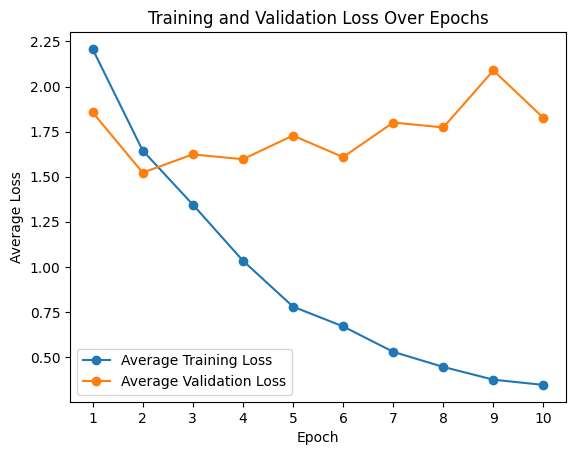

--------------------------------
Test for Full set
--------------------------------


Testing Progress:   0%|          | 0/549 [00:00<?, ?it/s]

Average test loss: 1.8256
RMSE: 1.3512
MSE: 1.8272
MAE: 1.0866
R²: -0.1983
R: 0.1973
True Skill Score: 0.2170
Accuracy: 0.7338
Precision: 0.3396
Recall: 0.2241
F1 Score: 0.2700


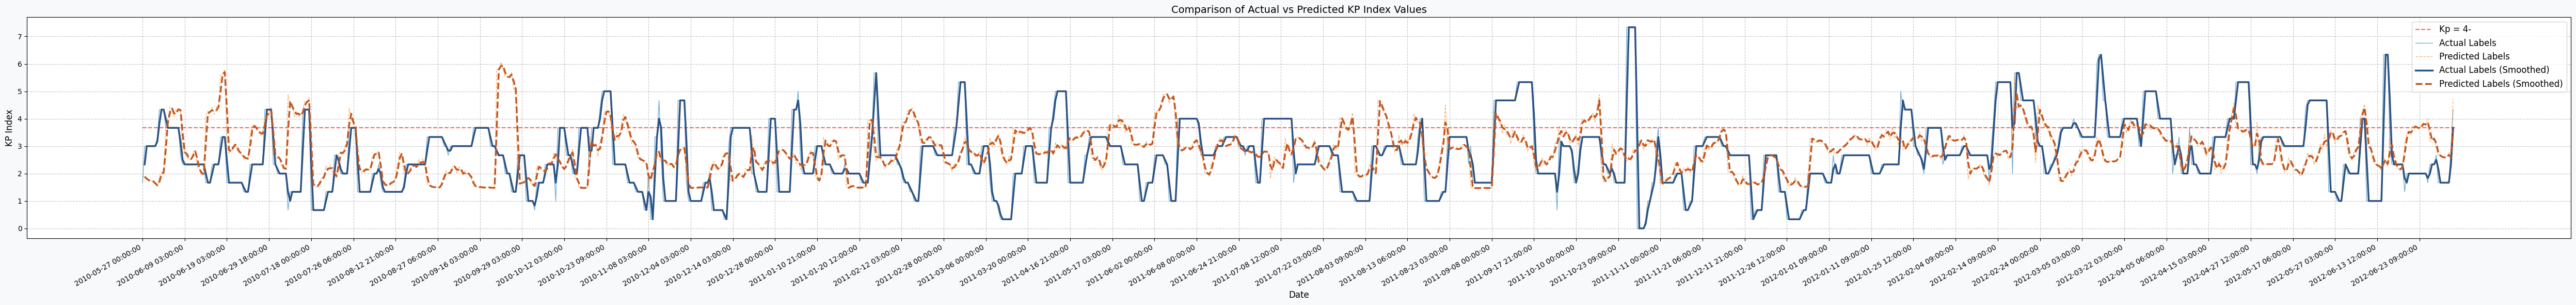

[np.float32(1.9375), np.float32(1.8359375), np.float32(1.7890625), np.float32(1.71875), np.float32(1.765625), np.float32(1.6796875), np.float32(1.6171875), np.float32(1.53125), np.float32(1.8671875), np.float32(2.0625), np.float32(2.015625), np.float32(3.71875), np.float32(4.0), np.float32(4.4375), np.float32(4.3125), np.float32(4.0625), np.float32(4.3125), np.float32(4.375), np.float32(4.25), np.float32(2.6875), np.float32(2.859375), np.float32(2.578125), np.float32(2.53125), np.float32(2.515625), np.float32(2.78125), np.float32(2.84375), np.float32(2.203125), np.float32(2.140625), np.float32(1.9140625), np.float32(2.0625), np.float32(4.09375), np.float32(4.28125), np.float32(4.21875), np.float32(4.40625), np.float32(4.15625), np.float32(4.4375), np.float32(4.40625), np.float32(5.59375), np.float32(5.625), np.float32(5.78125), np.float32(3.0), np.float32(2.734375), np.float32(2.859375), np.float32(3.03125), np.float32(3.078125), np.float32(2.796875), np.float32(2.78125), np.float32(2.

Testing Progress:   0%|          | 0/121 [00:00<?, ?it/s]

Average test loss: 2.9799
RMSE: 1.7262
MSE: 2.9896
MAE: 1.4714
R²: -3.8334
R: 0.1964
True Skill Score: 0.0000
Accuracy: 0.2241
Precision: 1.0000
Recall: 0.2241
F1 Score: 0.3661


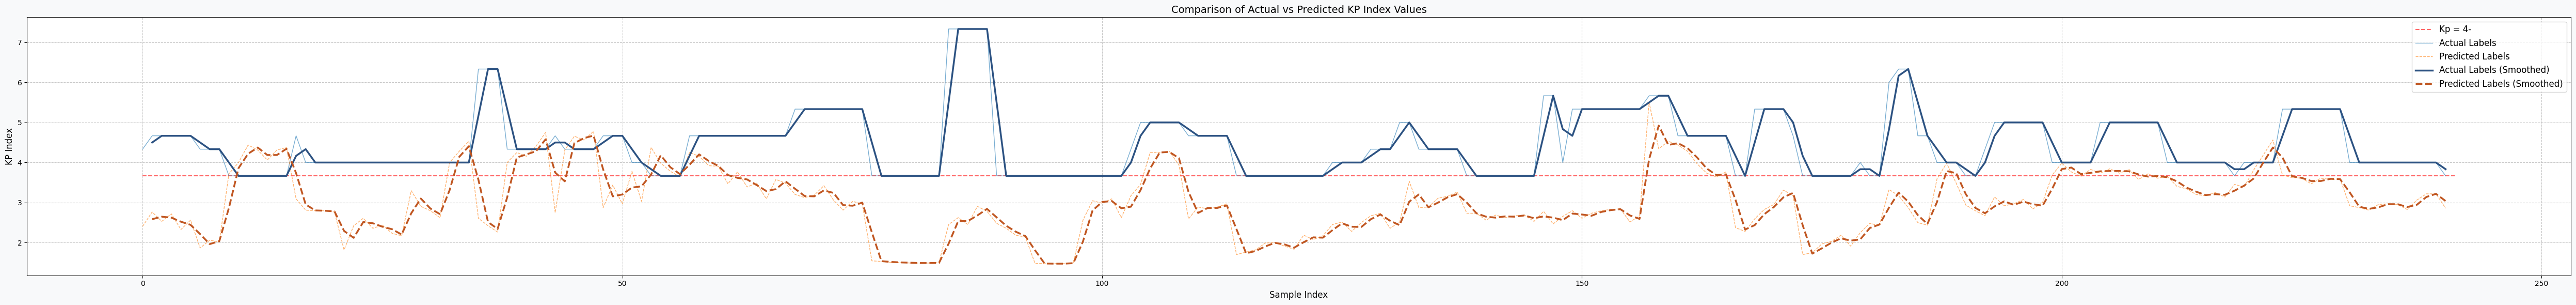

[np.float32(2.40625), np.float32(2.765625), np.float32(2.53125), np.float32(2.71875), np.float32(2.328125), np.float32(2.5625), np.float32(1.8671875), np.float32(2.0625), np.float32(2.015625), np.float32(3.71875), np.float32(4.0), np.float32(4.4375), np.float32(4.3125), np.float32(4.0625), np.float32(4.3125), np.float32(4.375), np.float32(3.09375), np.float32(2.8125), np.float32(2.796875), np.float32(2.796875), np.float32(2.765625), np.float32(1.8203125), np.float32(2.421875), np.float32(2.609375), np.float32(2.359375), np.float32(2.4375), np.float32(2.234375), np.float32(2.171875), np.float32(3.296875), np.float32(2.90625), np.float32(2.796875), np.float32(2.625), np.float32(4.0), np.float32(4.28125), np.float32(4.53125), np.float32(2.609375), np.float32(2.421875), np.float32(2.265625), np.float32(4.0), np.float32(4.25), np.float32(4.15625), np.float32(4.40625), np.float32(4.75), np.float32(2.75), np.float32(4.3125), np.float32(4.65625), np.float32(4.5625), np.float32(4.78125), np.flo

Training Progress: Epoch: 1:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  2.1797972468436


Validation Progress: Epoch: 1:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  2.0290260980450587


Training Progress: Epoch: 2:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  1.5789660338379743


Validation Progress: Epoch: 2:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  1.7596029855768163


Training Progress: Epoch: 3:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  1.2470471015125237


Validation Progress: Epoch: 3:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  1.7660818355666255


Training Progress: Epoch: 4:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  0.9516011873420311


Validation Progress: Epoch: 4:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  1.8223094779651416


Training Progress: Epoch: 5:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  0.7566349996050983


Validation Progress: Epoch: 5:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  1.9112071415447827


Training Progress: Epoch: 6:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  0.6055946065196481


Validation Progress: Epoch: 6:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  2.0763672651607035


Training Progress: Epoch: 7:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  0.5335196159896474


Validation Progress: Epoch: 7:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  1.940571012444276


Training Progress: Epoch: 8:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  0.44757233803342933


Validation Progress: Epoch: 8:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  2.0493106751853203


Training Progress: Epoch: 9:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  0.38359285526737097


Validation Progress: Epoch: 9:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  1.998513584599965


Training Progress: Epoch: 10:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  0.3360326213046568


Validation Progress: Epoch: 10:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  2.4000433955196536


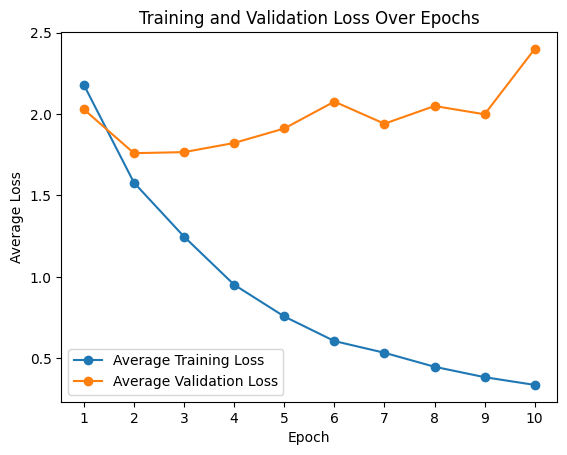

--------------------------------
Test for Full set
--------------------------------


Testing Progress:   0%|          | 0/549 [00:00<?, ?it/s]

Average test loss: 2.4000
RMSE: 1.5492
MSE: 2.4015
MAE: 1.2466
R²: -0.3926
R: 0.2252
True Skill Score: -0.0423
Accuracy: 0.6408
Precision: 0.2902
Recall: 0.5360
F1 Score: 0.3766


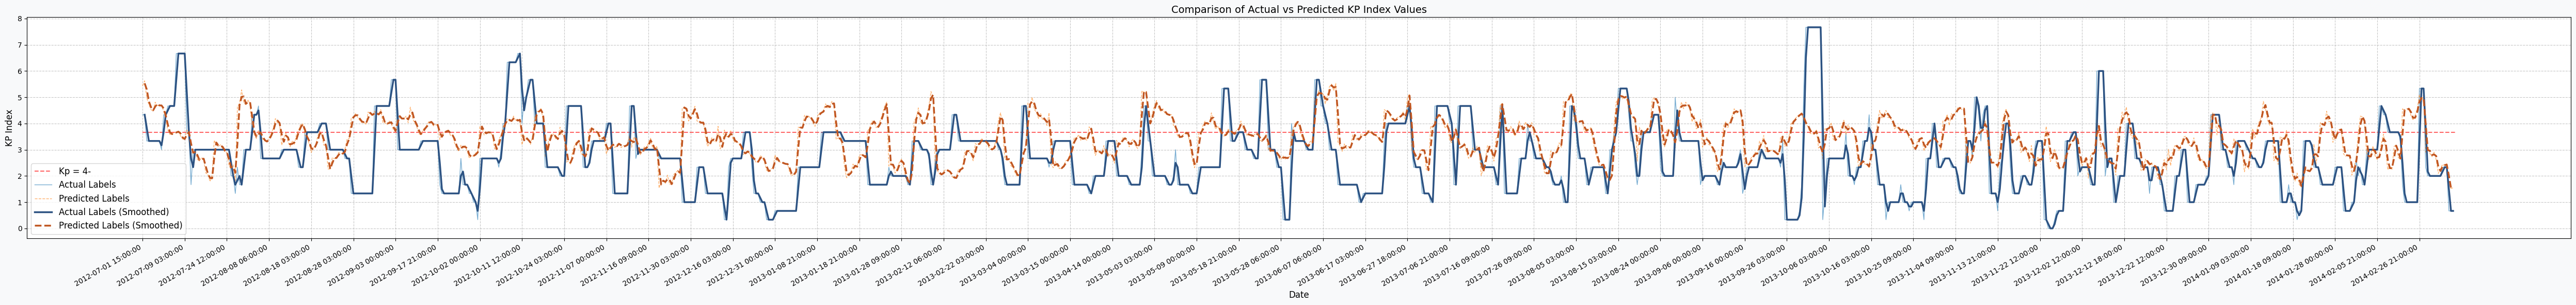

[np.float32(5.4375), np.float32(5.625), np.float32(4.96875), np.float32(4.71875), np.float32(4.53125), np.float32(4.46875), np.float32(4.8125), np.float32(4.6875), np.float32(4.6875), np.float32(4.6875), np.float32(4.46875), np.float32(4.15625), np.float32(3.75), np.float32(3.578125), np.float32(3.609375), np.float32(3.65625), np.float32(3.65625), np.float32(3.71875), np.float32(3.53125), np.float32(3.40625), np.float32(3.40625), np.float32(3.75), np.float32(3.59375), np.float32(2.890625), np.float32(2.875), np.float32(2.96875), np.float32(2.625), np.float32(2.578125), np.float32(2.703125), np.float32(2.609375), np.float32(2.109375), np.float32(2.0625), np.float32(1.7890625), np.float32(2.03125), np.float32(3.359375), np.float32(3.1875), np.float32(3.125), np.float32(3.1875), np.float32(3.03125), np.float32(2.921875), np.float32(2.890625), np.float32(2.390625), np.float32(2.265625), np.float32(2.421875), np.float32(1.8203125), np.float32(4.65625), np.float32(4.75), np.float32(5.28125),

Testing Progress:   0%|          | 0/111 [00:00<?, ?it/s]

Average test loss: 2.0688
RMSE: 1.4383
MSE: 2.0688
MAE: 1.0580
R²: -1.2264
R: 0.0438
True Skill Score: 0.0000
Accuracy: 0.5360
Precision: 1.0000
Recall: 0.5360
F1 Score: 0.6979


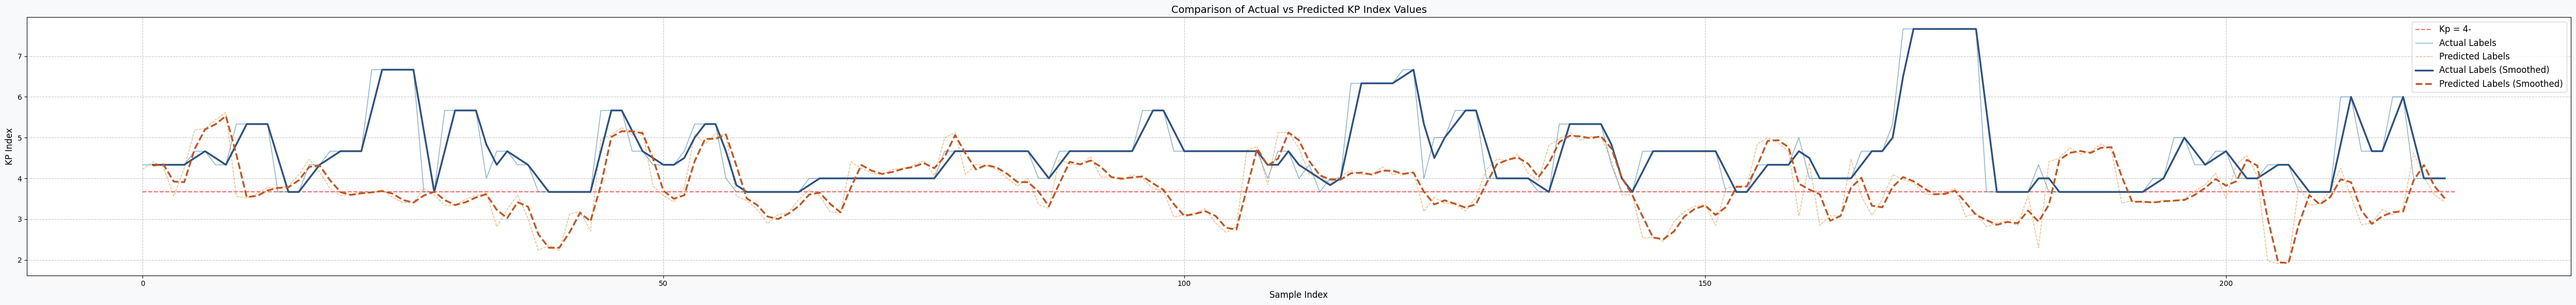

[np.float32(4.21875), np.float32(4.40625), np.float32(4.28125), np.float32(3.5625), np.float32(4.25), np.float32(5.1875), np.float32(5.21875), np.float32(5.4375), np.float32(5.625), np.float32(3.5625), np.float32(3.515625), np.float32(3.625), np.float32(3.78125), np.float32(3.75), np.float32(3.8125), np.float32(4.09375), np.float32(4.46875), np.float32(4.15625), np.float32(3.75), np.float32(3.578125), np.float32(3.609375), np.float32(3.65625), np.float32(3.65625), np.float32(3.71875), np.float32(3.53125), np.float32(3.40625), np.float32(3.40625), np.float32(3.75), np.float32(3.59375), np.float32(3.34375), np.float32(3.34375), np.float32(3.484375), np.float32(3.578125), np.float32(3.640625), np.float32(2.8125), np.float32(3.234375), np.float32(3.59375), np.float32(3.015625), np.float32(2.234375), np.float32(2.359375), np.float32(2.234375), np.float32(3.125), np.float32(3.1875), np.float32(2.703125), np.float32(4.96875), np.float32(5.0625), np.float32(5.25), np.float32(5.0625), np.float3

Training Progress: Epoch: 1:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  2.077355283972275


Validation Progress: Epoch: 1:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  1.7818056088696252


Training Progress: Epoch: 2:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  1.6146265744854291


Validation Progress: Epoch: 2:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  1.9694269793867376


Training Progress: Epoch: 3:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  1.2949641909026812


Validation Progress: Epoch: 3:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  1.6870262025904676


Training Progress: Epoch: 4:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  0.9740883657948489


Validation Progress: Epoch: 4:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  2.087207759489629


Training Progress: Epoch: 5:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  0.7525531332605467


Validation Progress: Epoch: 5:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  1.905342770080067


Training Progress: Epoch: 6:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  0.6055145169609373


Validation Progress: Epoch: 6:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  1.906953680671061


Training Progress: Epoch: 7:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  0.4882163097510477


Validation Progress: Epoch: 7:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  2.0636660078491036


Training Progress: Epoch: 8:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  0.3946377973863802


Validation Progress: Epoch: 8:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  2.308052104182765


Training Progress: Epoch: 9:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  0.3426225057172887


Validation Progress: Epoch: 9:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  1.928537570203138


Training Progress: Epoch: 10:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  0.30621768266652344


Validation Progress: Epoch: 10:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  2.059546349587331


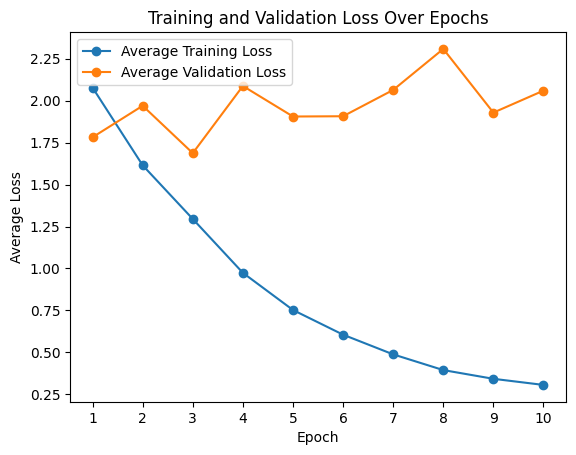

--------------------------------
Test for Full set
--------------------------------


Testing Progress:   0%|          | 0/549 [00:00<?, ?it/s]

Average test loss: 2.0595
RMSE: 1.4351
MSE: 2.0613
MAE: 1.1480
R²: -0.2131
R: 0.2786
True Skill Score: 0.3333
Accuracy: 0.6281
Precision: 0.3944
Recall: 0.0712
F1 Score: 0.1207


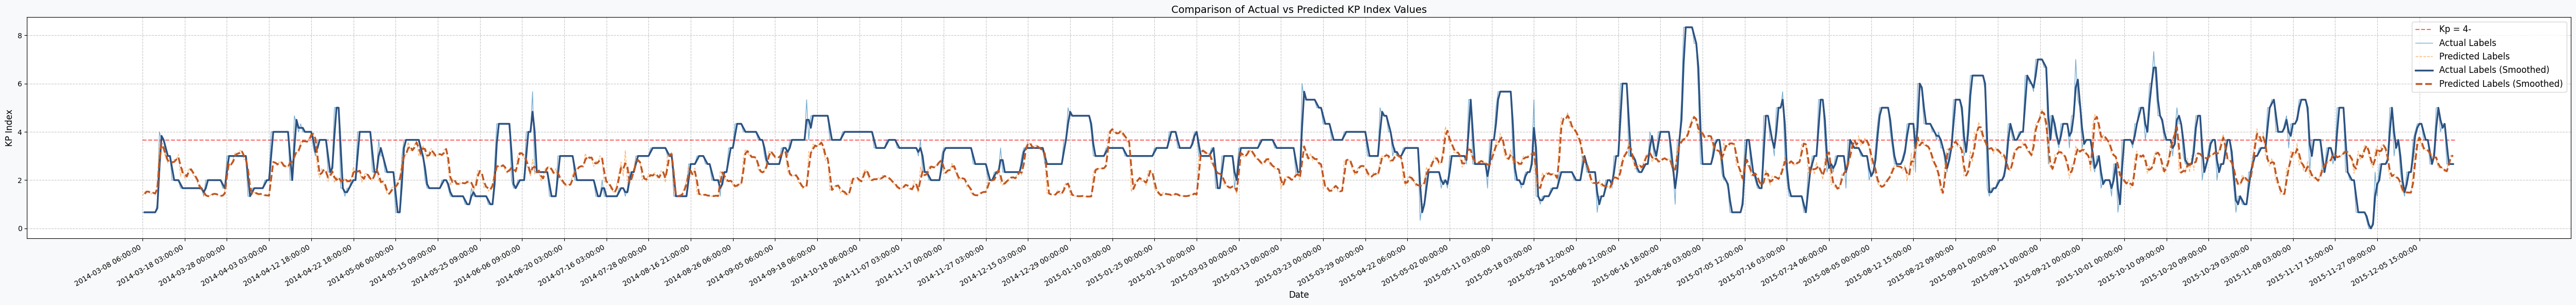

[np.float32(1.3515625), np.float32(1.5078125), np.float32(1.546875), np.float32(1.4921875), np.float32(1.421875), np.float32(1.5234375), np.float32(1.375), np.float32(1.9140625), np.float32(3.625), np.float32(3.4375), np.float32(3.203125), np.float32(2.921875), np.float32(2.703125), np.float32(2.828125), np.float32(2.65625), np.float32(2.859375), np.float32(2.84375), np.float32(3.0625), np.float32(2.15625), np.float32(2.484375), np.float32(2.0625), np.float32(2.234375), np.float32(2.5), np.float32(2.40625), np.float32(2.21875), np.float32(2.125), np.float32(1.9140625), np.float32(1.625), np.float32(1.6328125), np.float32(1.40625), np.float32(1.34375), np.float32(1.328125), np.float32(1.359375), np.float32(1.4453125), np.float32(1.421875), np.float32(1.421875), np.float32(1.3515625), np.float32(1.34375), np.float32(1.375), np.float32(1.515625), np.float32(2.765625), np.float32(2.65625), np.float32(2.640625), np.float32(2.90625), np.float32(3.15625), np.float32(3.03125), np.float32(3.218

Testing Progress:   0%|          | 0/197 [00:00<?, ?it/s]

Average test loss: 3.9998
RMSE: 1.9999
MSE: 3.9999
MAE: 1.8007
R²: -3.5745
R: 0.4725
True Skill Score: 0.0000
Accuracy: 0.0712
Precision: 1.0000
Recall: 0.0712
F1 Score: 0.1330


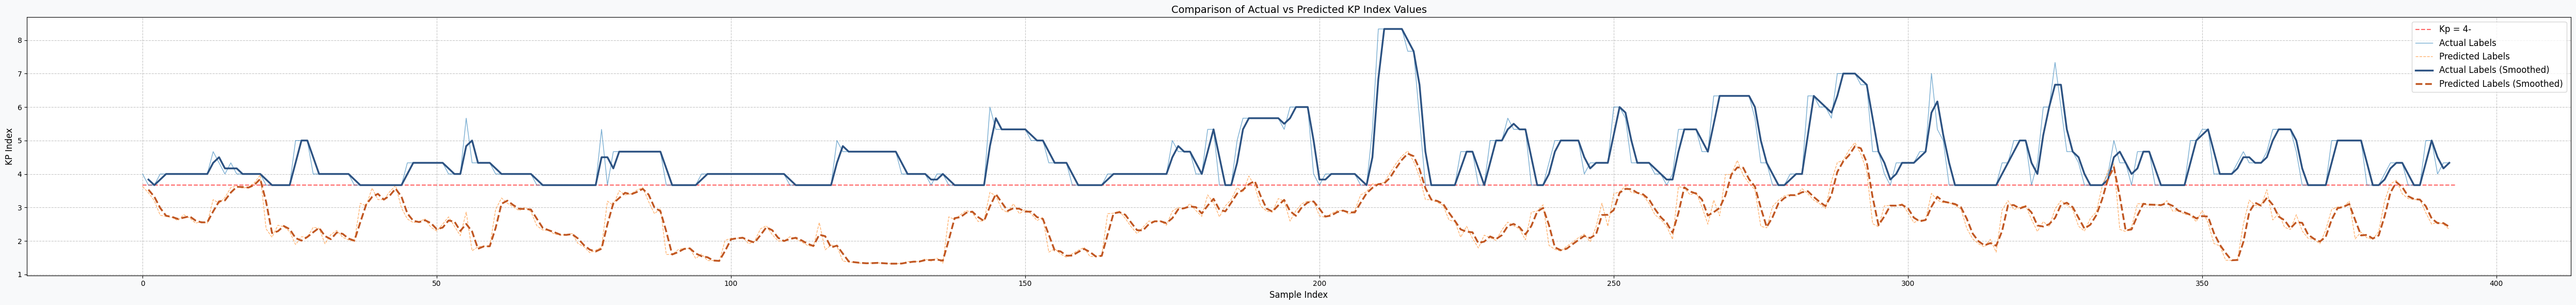

[np.float32(3.625), np.float32(3.4375), np.float32(3.203125), np.float32(2.765625), np.float32(2.734375), np.float32(2.703125), np.float32(2.609375), np.float32(2.78125), np.float32(2.6875), np.float32(2.53125), np.float32(2.578125), np.float32(2.53125), np.float32(3.234375), np.float32(3.125), np.float32(3.296875), np.float32(3.59375), np.float32(3.640625), np.float32(3.578125), np.float32(3.609375), np.float32(3.734375), np.float32(3.96875), np.float32(2.359375), np.float32(2.109375), np.float32(2.46875), np.float32(2.421875), np.float32(2.28125), np.float32(1.890625), np.float32(2.125), np.float32(2.109375), np.float32(2.40625), np.float32(2.375), np.float32(1.9140625), np.float32(2.1875), np.float32(2.3125), np.float32(2.109375), np.float32(2.03125), np.float32(1.984375), np.float32(3.125), np.float32(3.046875), np.float32(3.578125), np.float32(3.234375), np.float32(3.234375), np.float32(3.46875), np.float32(3.65625), np.float32(2.984375), np.float32(2.65625), np.float32(2.546875),

Training Progress: Epoch: 1:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  2.1524604069531508


Validation Progress: Epoch: 1:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  1.9159118473435162


Training Progress: Epoch: 2:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  1.619831466098194


Validation Progress: Epoch: 2:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  1.6528866586996713


Training Progress: Epoch: 3:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  1.330001425499665


Validation Progress: Epoch: 3:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  1.8706522528839282


Training Progress: Epoch: 4:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  1.0174487431094095


Validation Progress: Epoch: 4:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  1.9146282887238948


Training Progress: Epoch: 5:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  0.8069257213228651


Validation Progress: Epoch: 5:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  1.9529071784950836


Training Progress: Epoch: 6:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  0.6604579537174005


Validation Progress: Epoch: 6:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  2.2252062276319355


Training Progress: Epoch: 7:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  0.5534102819458759


Validation Progress: Epoch: 7:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  1.8698584388509794


Training Progress: Epoch: 8:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  0.45307797595382837


Validation Progress: Epoch: 8:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  1.9265447707632803


Training Progress: Epoch: 9:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  0.37197327865536933


Validation Progress: Epoch: 9:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  2.125859794119553


Training Progress: Epoch: 10:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  0.33368739859074686


Validation Progress: Epoch: 10:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  2.2904174751223736


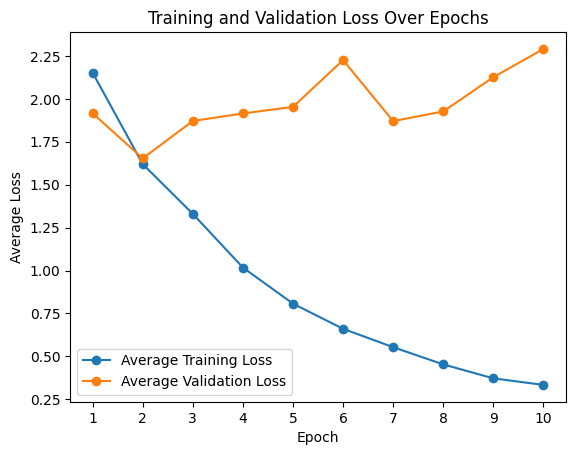

--------------------------------
Test for Full set
--------------------------------


Testing Progress:   0%|          | 0/549 [00:00<?, ?it/s]

Average test loss: 2.2904
RMSE: 1.5134
MSE: 2.2924
MAE: 1.2058
R²: -0.4106
R: 0.1843
True Skill Score: 0.3107
Accuracy: 0.6180
Precision: 0.5307
Recall: 0.3744
F1 Score: 0.4391


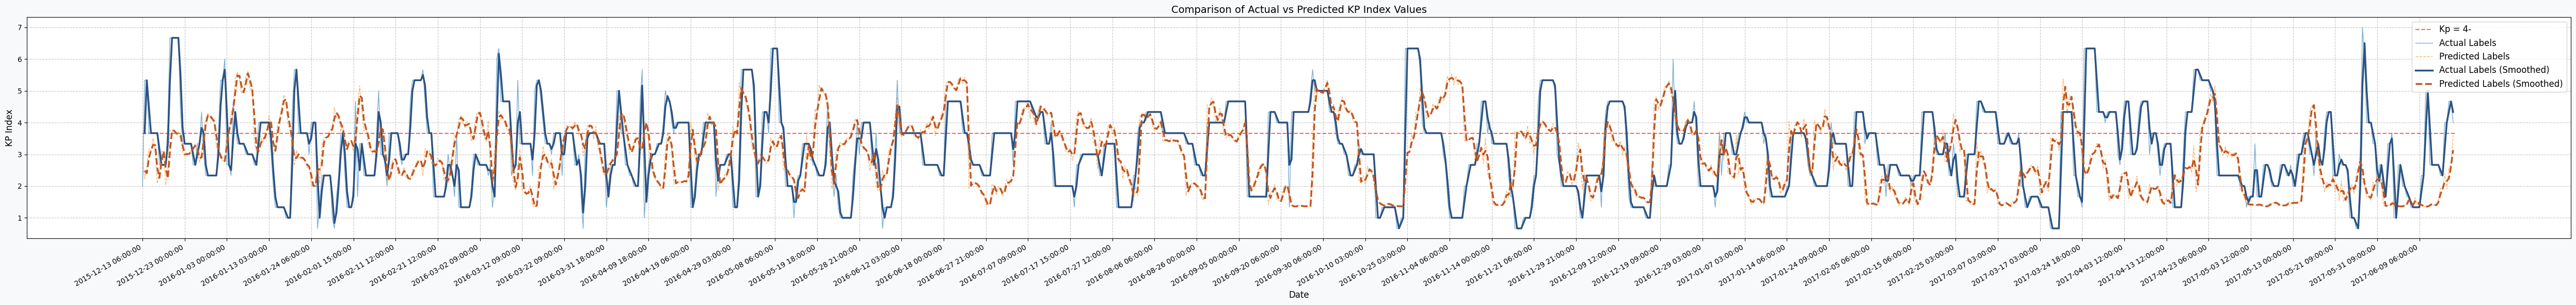

[np.float32(2.734375), np.float32(2.234375), np.float32(2.578125), np.float32(3.171875), np.float32(3.078125), np.float32(3.515625), np.float32(3.0625), np.float32(2.078125), np.float32(2.4375), np.float32(3.09375), np.float32(3.109375), np.float32(2.03125), np.float32(2.453125), np.float32(3.765625), np.float32(3.75), np.float32(3.734375), np.float32(3.59375), np.float32(3.703125), np.float32(3.5), np.float32(3.0625), np.float32(2.953125), np.float32(3.046875), np.float32(2.984375), np.float32(3.140625), np.float32(3.21875), np.float32(3.328125), np.float32(3.03125), np.float32(2.75), np.float32(3.046875), np.float32(3.78125), np.float32(4.125), np.float32(4.3125), np.float32(4.15625), np.float32(4.09375), np.float32(3.984375), np.float32(3.21875), np.float32(3.0625), np.float32(2.859375), np.float32(2.796875), np.float32(2.78125), np.float32(3.765625), np.float32(3.703125), np.float32(4.3125), np.float32(4.53125), np.float32(5.375), np.float32(5.59375), np.float32(5.34375), np.float3

Testing Progress:   0%|          | 0/219 [00:00<?, ?it/s]

Average test loss: 2.8712
RMSE: 1.6945
MSE: 2.8712
MAE: 1.3522
R²: -4.0673
R: 0.1309
True Skill Score: 0.0000
Accuracy: 0.3744
Precision: 1.0000
Recall: 0.3744
F1 Score: 0.5449


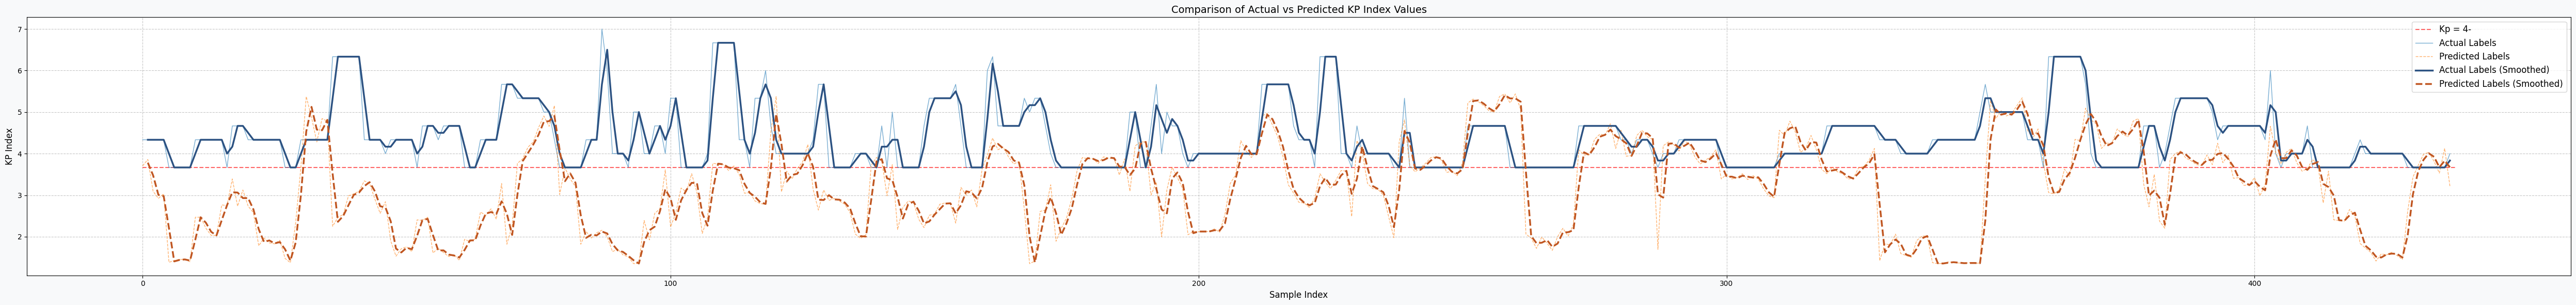

[np.float32(3.703125), np.float32(3.859375), np.float32(3.09375), np.float32(2.921875), np.float32(3.03125), np.float32(1.3828125), np.float32(1.4296875), np.float32(1.453125), np.float32(1.453125), np.float32(1.3984375), np.float32(2.46875), np.float32(2.46875), np.float32(2.203125), np.float32(2.03125), np.float32(2.03125), np.float32(2.765625), np.float32(2.75), np.float32(3.390625), np.float32(2.734375), np.float32(3.125), np.float32(2.734375), np.float32(2.578125), np.float32(1.78125), np.float32(1.96875), np.float32(1.8515625), np.float32(1.828125), np.float32(1.9140625), np.float32(1.4765625), np.float32(1.375), np.float32(2.34375), np.float32(3.6875), np.float32(5.375), np.float32(4.875), np.float32(4.28125), np.float32(4.84375), np.float32(4.78125), np.float32(2.25), np.float32(2.46875), np.float32(2.53125), np.float32(2.984375), np.float32(3.03125), np.float32(3.09375), np.float32(3.34375), np.float32(3.28125), np.float32(2.90625), np.float32(2.5625), np.float32(2.84375), np.

Training Progress: Epoch: 1:   0%|          | 0/2194 [00:00<?, ?it/s]

Average Training Loss:  2.154448075207095


Validation Progress: Epoch: 1:   0%|          | 0/550 [00:00<?, ?it/s]

Average Validation Loss:  1.5704537903719888


Training Progress: Epoch: 2:   0%|          | 0/2194 [00:00<?, ?it/s]

Average Training Loss:  1.6334066574790556


Validation Progress: Epoch: 2:   0%|          | 0/550 [00:00<?, ?it/s]

Average Validation Loss:  1.5485735435641121


Training Progress: Epoch: 3:   0%|          | 0/2194 [00:00<?, ?it/s]

Average Training Loss:  1.360788748072563


Validation Progress: Epoch: 3:   0%|          | 0/550 [00:00<?, ?it/s]

Average Validation Loss:  1.5162313071517102


Training Progress: Epoch: 4:   0%|          | 0/2194 [00:00<?, ?it/s]

Average Training Loss:  1.0754350915441429


Validation Progress: Epoch: 4:   0%|          | 0/550 [00:00<?, ?it/s]

Average Validation Loss:  1.568771009946517


Training Progress: Epoch: 5:   0%|          | 0/2194 [00:00<?, ?it/s]

Average Training Loss:  0.8244083822338228


Validation Progress: Epoch: 5:   0%|          | 0/550 [00:00<?, ?it/s]

Average Validation Loss:  1.5803307550988923


Training Progress: Epoch: 6:   0%|          | 0/2194 [00:00<?, ?it/s]

Average Training Loss:  0.6457259437796786


Validation Progress: Epoch: 6:   0%|          | 0/550 [00:00<?, ?it/s]

Average Validation Loss:  1.8448194310322024


Training Progress: Epoch: 7:   0%|          | 0/2194 [00:00<?, ?it/s]

Average Training Loss:  0.5508686685343185


Validation Progress: Epoch: 7:   0%|          | 0/550 [00:00<?, ?it/s]

Average Validation Loss:  1.5207242056552785


Training Progress: Epoch: 8:   0%|          | 0/2194 [00:00<?, ?it/s]

Average Training Loss:  0.43298183512545924


Validation Progress: Epoch: 8:   0%|          | 0/550 [00:00<?, ?it/s]

Average Validation Loss:  1.52456937536248


Training Progress: Epoch: 9:   0%|          | 0/2194 [00:00<?, ?it/s]

Average Training Loss:  0.3869426334475508


Validation Progress: Epoch: 9:   0%|          | 0/550 [00:00<?, ?it/s]

Average Validation Loss:  1.6151988994129087


Training Progress: Epoch: 10:   0%|          | 0/2194 [00:00<?, ?it/s]

Average Training Loss:  0.3275378129168805


Validation Progress: Epoch: 10:   0%|          | 0/550 [00:00<?, ?it/s]

Average Validation Loss:  1.5830539678520819


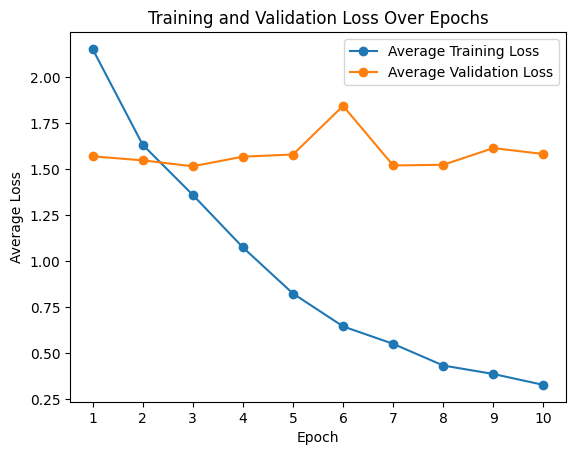

--------------------------------
Test for Full set
--------------------------------


Testing Progress:   0%|          | 0/550 [00:00<?, ?it/s]

Average test loss: 1.5831
RMSE: 1.2582
MSE: 1.5836
MAE: 1.0027
R²: 0.0590
R: 0.3626
True Skill Score: 0.3679
Accuracy: 0.7325
Precision: 0.4524
Recall: 0.2021
F1 Score: 0.2794


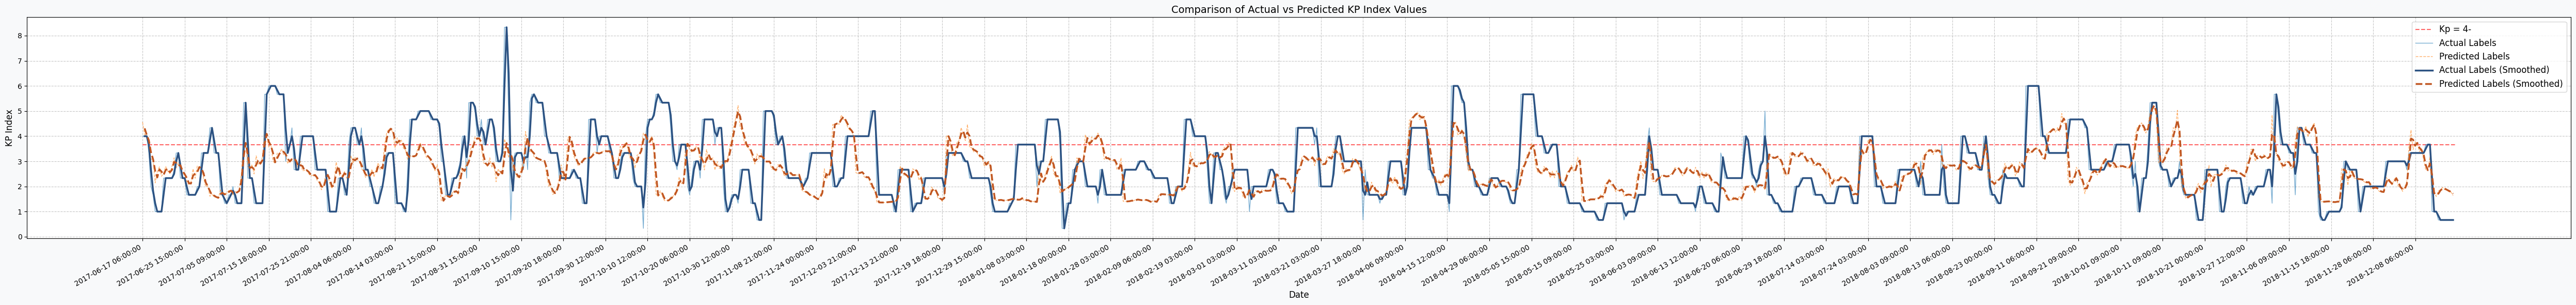

[np.float32(4.5625), np.float32(4.0625), np.float32(4.03125), np.float32(3.640625), np.float32(3.078125), np.float32(3.09375), np.float32(2.140625), np.float32(2.578125), np.float32(2.78125), np.float32(2.40625), np.float32(2.515625), np.float32(2.796875), np.float32(2.609375), np.float32(2.515625), np.float32(2.8125), np.float32(3.140625), np.float32(2.734375), np.float32(2.9375), np.float32(2.75), np.float32(2.484375), np.float32(2.5), np.float32(2.1875), np.float32(2.078125), np.float32(2.15625), np.float32(2.703125), np.float32(2.328125), np.float32(2.8125), np.float32(2.734375), np.float32(2.703125), np.float32(2.34375), np.float32(1.984375), np.float32(2.03125), np.float32(1.609375), np.float32(1.6875), np.float32(1.5859375), np.float32(1.578125), np.float32(1.5234375), np.float32(1.859375), np.float32(1.6328125), np.float32(1.734375), np.float32(1.71875), np.float32(1.84375), np.float32(1.828125), np.float32(1.6640625), np.float32(1.796875), np.float32(1.7421875), np.float32(1.9

Testing Progress:   0%|          | 0/141 [00:00<?, ?it/s]

Average test loss: 3.0139
RMSE: 1.7361
MSE: 3.0139
MAE: 1.4991
R²: -4.0987
R: 0.2232
True Skill Score: 0.0000
Accuracy: 0.2021
Precision: 1.0000
Recall: 0.2021
F1 Score: 0.3363


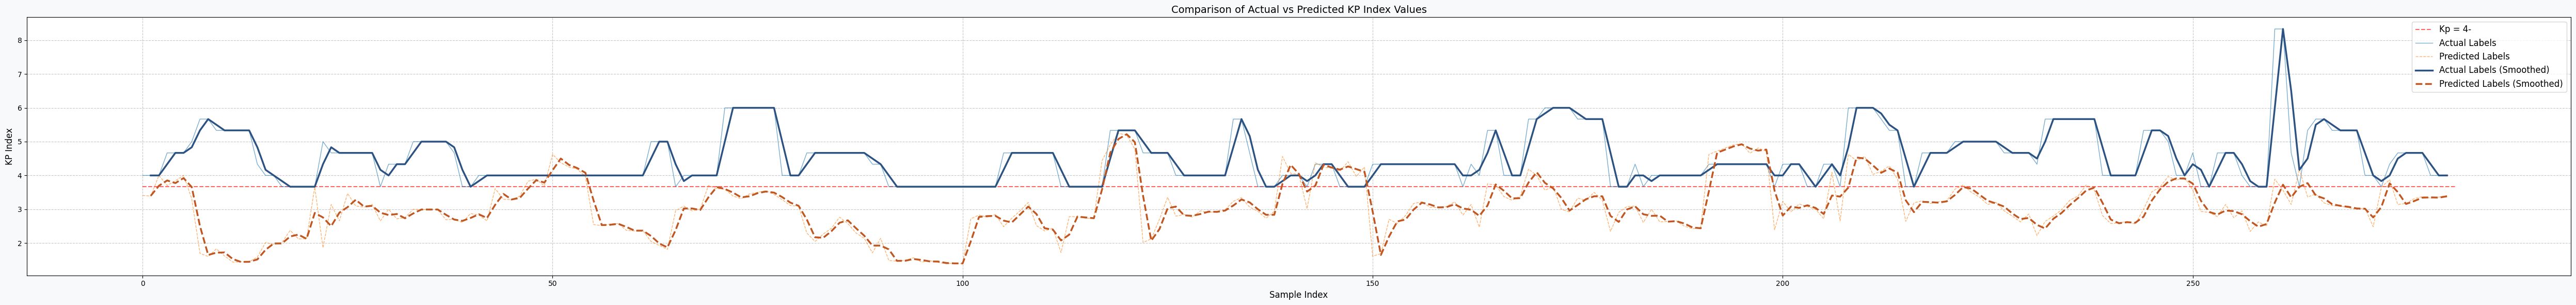

[np.float32(3.40625), np.float32(3.390625), np.float32(4.0), np.float32(3.703125), np.float32(3.84375), np.float32(4.0), np.float32(3.3125), np.float32(1.6953125), np.float32(1.6015625), np.float32(1.828125), np.float32(1.6171875), np.float32(1.4375), np.float32(1.4453125), np.float32(1.4453125), np.float32(1.5859375), np.float32(2.015625), np.float32(1.9609375), np.float32(2.015625), np.float32(2.375), np.float32(2.125), np.float32(2.125), np.float32(3.65625), np.float32(1.859375), np.float32(3.140625), np.float32(2.65625), np.float32(3.46875), np.float32(3.09375), np.float32(3.0625), np.float32(3.140625), np.float32(2.65625), np.float32(3.0), np.float32(2.71875), np.float32(2.75), np.float32(3.0), np.float32(2.984375), np.float32(3.0), np.float32(2.984375), np.float32(2.6875), np.float32(2.703125), np.float32(2.609375), np.float32(2.875), np.float32(2.828125), np.float32(2.65625), np.float32(3.609375), np.float32(3.296875), np.float32(3.28125), np.float32(3.390625), np.float32(3.8281

In [ ]:
torch.set_float32_matmul_precision('medium')
fabric = Fabric(accelerator='cuda', devices=1, precision="bf16-mixed")
fabric.launch(train_model)


In [ ]:
# prompt: disconnect runtime
import time
time.sleep(5 * 60)
from google.colab import runtime
runtime.unassign()
